# Panagram-like plotting

## Imports and helper functions

In [1]:
import pandas as pd
import numpy as np
from collections import Counter

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mplpatches
%matplotlib inline

plt.rcParams['figure.dpi'] = 300

In [3]:
# import plotnine
from plotnine import \
    ggplot, aes, theme, themes, element_blank, element_line, element_text, mapping, \
    geom_point, geom_jitter, geom_line, geom_bar, geom_boxplot, geom_violin, geom_histogram, \
    ggtitle, xlab, ylab, geom_vline, geom_hline, geom_col, \
    scale_x_discrete, scale_y_discrete, scale_x_continuous, scale_y_continuous, \
    scale_color_discrete, scale_fill_manual, scale_fill_hue, scale_fill_gradient, scale_color_manual, scale_color_hue, \
    guides, \
    xlim, ylim
from plotnine.options import figure_size


# plotnine theme
def theme_tufte_func(base_size=19, base_family="sans", rotate=True, figure_size=None):
    ''' Plotnine plotting theme. '''
    thm = themes.theme_bw(base_size=base_size, base_family = base_family) + \
        theme(
            legend_background = element_blank(),
            legend_key = element_blank(),
            panel_background = element_blank(),
            panel_border = element_blank(),
            strip_background = element_blank(),
            plot_background = element_blank(),
            panel_grid = element_blank(),
            axis_line = element_line(colour = "black", size = 1),
            axis_text_y = element_text(colour = "black")
        )

    if rotate:
        thm += theme(axis_text_x=element_text(rotation=45, hjust=1))
    if figure_size is not None:
        thm += theme(figure_size=figure_size)
    return thm


In [4]:
# Reading a file
def fileReader(path):
    ''' Read file from path line-by-line. '''
    with open(path, 'r') as inFile:
        for line in inFile:
            yield line.strip()


## Panagram plot

In [26]:
#path = '/Users/stephenhwang/Documents/projects/langmead_lab/omem/data/memo_hla_conservation.out'
path = '/Users/stephenhwang/Documents/projects/langmead_lab/omem/data/memo_hla_conservation.deciles.out'


In [27]:
n_bins = 700

In [28]:
num_docs_per_pos = list(map(int, list(fileReader(path))))
positions = len(num_docs_per_pos)

per_bin_doc_composition_list = []
bin_space = list(map(int,np.linspace(0, positions, n_bins)))

for bin_idx, start_end in enumerate(list(zip(bin_space[:-1], bin_space[1:]))):
    bin_start, bin_end = start_end
    doc_count_per_order_in_bin = Counter(num_docs_per_pos[bin_start : bin_end])
    normalized_doc_count_per_order_in_bin = [(order, doc_count_per_order_in_bin[order]/sum(doc_count_per_order_in_bin.values())) for order in range(90) ]
    normalized_doc_count_per_order_in_bin_in_sorted_order_mem_order = sorted(normalized_doc_count_per_order_in_bin, key=lambda x: x[0])   # sorting by order
    per_bin_doc_composition_list.append([bin_idx]+[norm_cnt[1] for norm_cnt in normalized_doc_count_per_order_in_bin_in_sorted_order_mem_order])

cnames = ['pos'] + list(range(90))
per_bin_doc_composition_df = pd.DataFrame(per_bin_doc_composition_list, columns=cnames)

per_bin_doc_composition_df = pd.melt(per_bin_doc_composition_df, id_vars=['pos'], value_vars=cnames[1:])
per_bin_doc_composition_df.columns = ['bin','Num docs','value']

per_bin_doc_composition_df['Num docs'] = pd.Categorical(per_bin_doc_composition_df['Num docs'], categories=cnames[:0:-1])
per_bin_doc_composition_df['Num. Genomes'] = per_bin_doc_composition_df['Num docs'].astype('float64')
per_bin_doc_composition_df

,bin,Num docs,value,Num. Genomes
0,0,0,0.000000,0.0
1,1,0,0.000000,0.0
2,2,0,0.000000,0.0
3,3,0,0.000000,0.0
4,4,0,0.000000,0.0
...,...,...,...,...
62905,694,89,0.884379,89.0
62906,695,89,0.844163,89.0
62907,696,89,0.880469,89.0
62908,697,89,0.873953,89.0


In [30]:
breaks

[1, 11, 22, 33, 44, 55, 66, 77, 88]

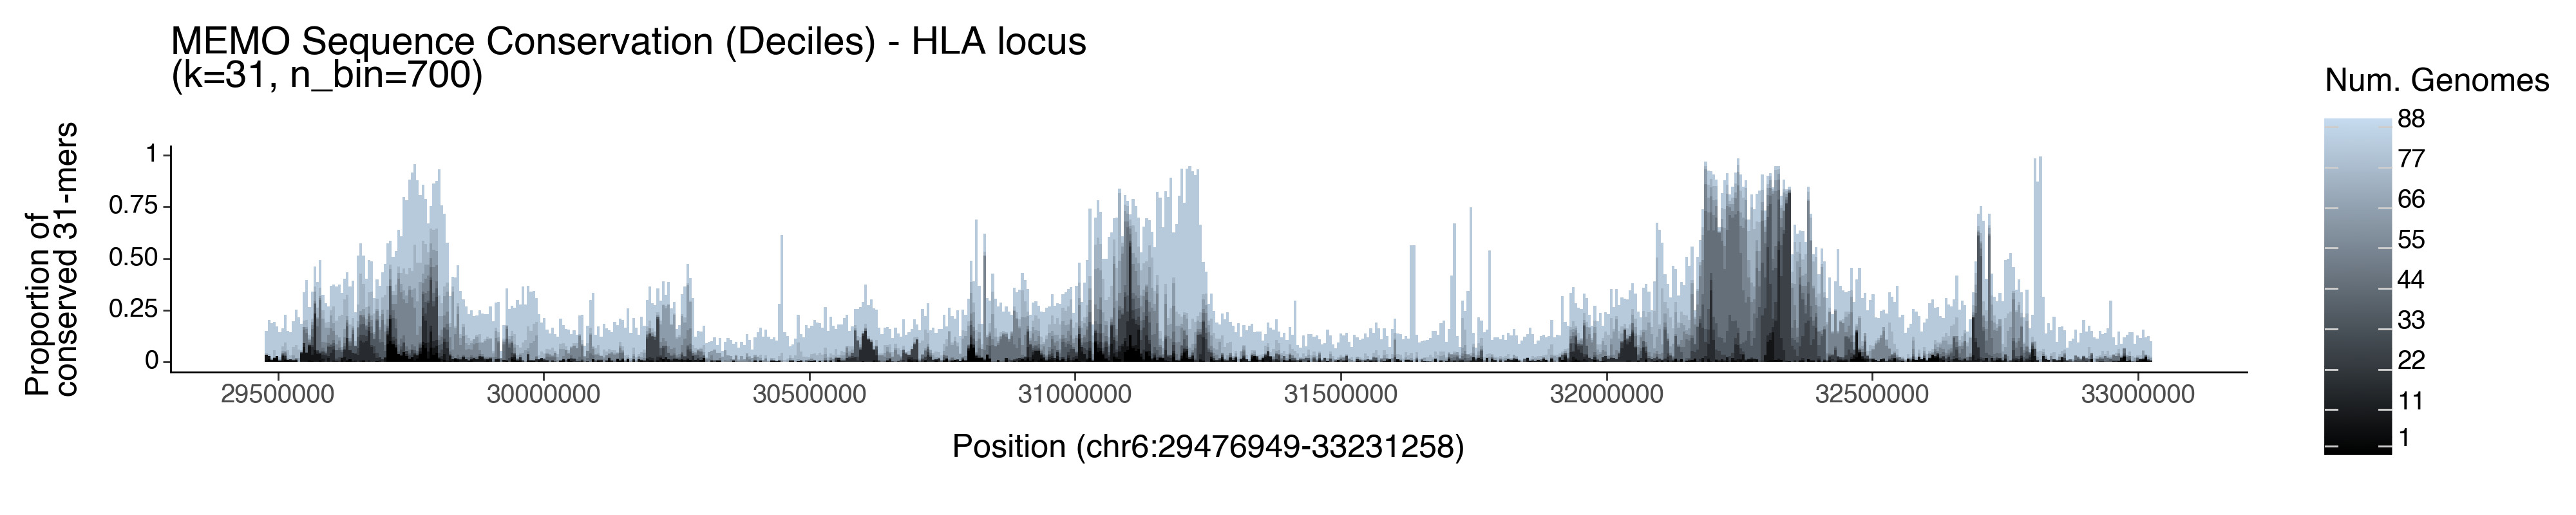

<Figure Size: (2000 x 400)>

In [29]:
################### DECILES ###################

#data = per_bin_doc_composition_df
data = per_bin_doc_composition_df[per_bin_doc_composition_df['Num docs'] != 89]

# plot MEM-version of Panagram
(
    ggplot(data, aes(x='bin', y='value', fill='Num. Genomes')) +
    geom_bar(stat="identity", width=1) +
    ggtitle("MEMO Sequence Conservation (Deciles) - HLA locus\n(k=31, n_bin=700)") +
    xlab("Position (chr6:29476949-33231258)") +
    ylab("Proportion of\nconserved 31-mers") +
    scale_x_continuous(
        breaks=np.linspace(0+4.297913597971398, 699-5.828128204650122, 8),
        labels=list(range(29_500_000, 33_200_000, 500_000))) +
    scale_fill_gradient(low='#000000', high='#c6dbef',
                        breaks=breaks,
                        labels=breaks,
                        limits=(1,88)
                       ) +
    theme_tufte_func(base_size=18, rotate=False, figure_size=[20,4])
)


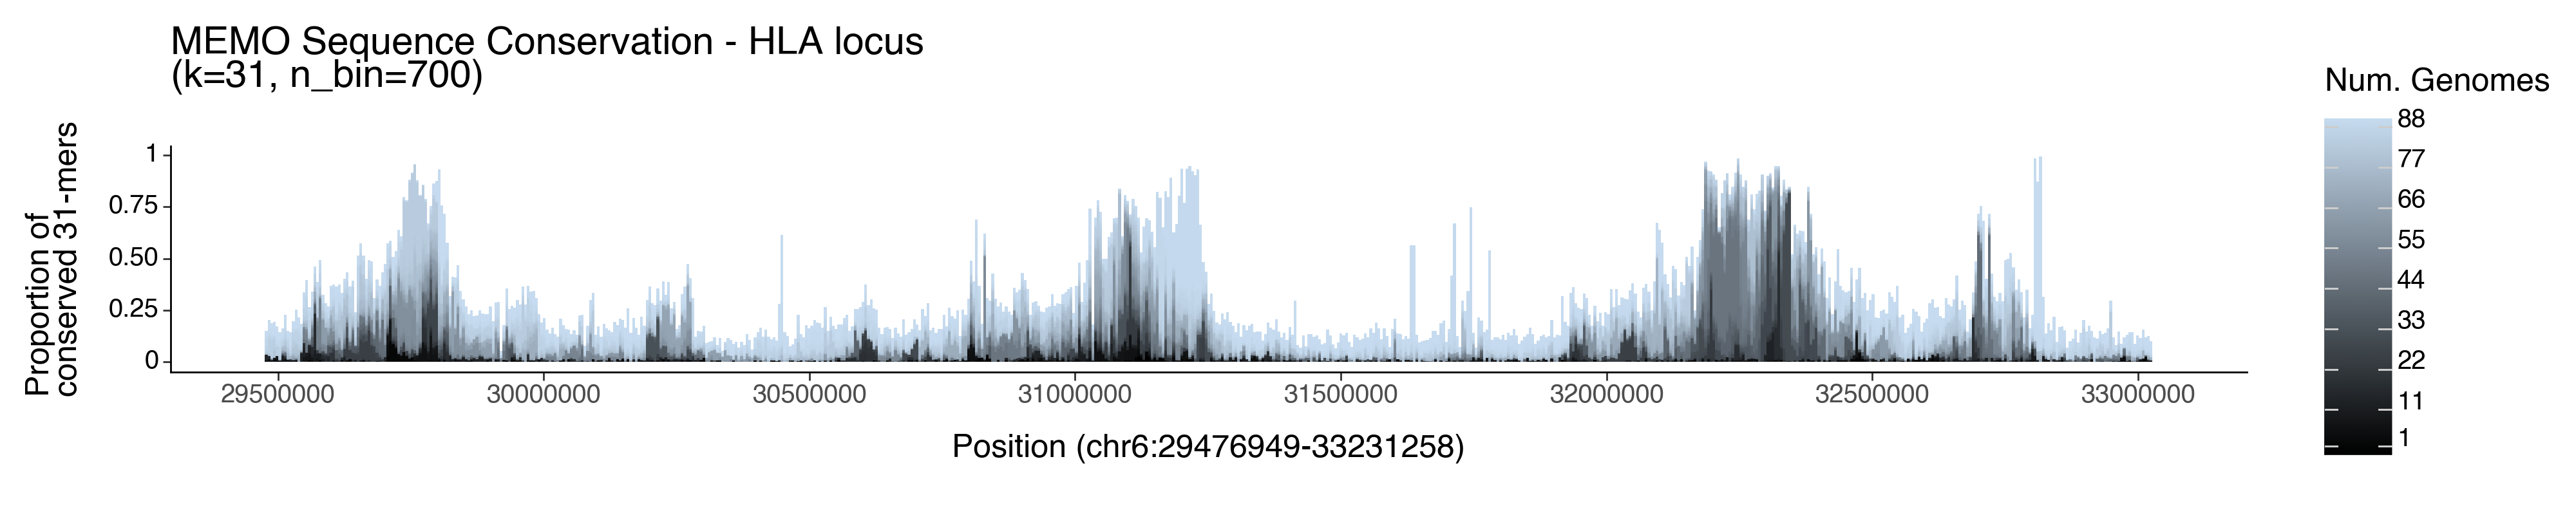

<Figure Size: (2000 x 400)>

In [22]:
################### FULL ###################

#data = per_bin_doc_composition_df
data = per_bin_doc_composition_df[per_bin_doc_composition_df['Num docs'] != 89]

# plot MEM-version of Panagram
(
    ggplot(data, aes(x='bin', y='value', fill='Num. Genomes')) +
    geom_bar(stat="identity", width=1) +
    ggtitle("MEMO Sequence Conservation - HLA locus\n(k=31, n_bin=700)") +
    xlab("Position (chr6:29476949-33231258)") +
    ylab("Proportion of\nconserved 31-mers") +
    scale_x_continuous(
        breaks=np.linspace(0+4.297913597971398, 699-5.828128204650122, 8),
        labels=list(range(29_500_000, 33_200_000, 500_000))) +
    scale_fill_gradient(low='#000000', high='#c6dbef',
                        breaks=breaks,
                        labels=breaks,
                        limits=(1,88)
                       ) +
    theme_tufte_func(base_size=18, rotate=False, figure_size=[20,4])
)


In [120]:
readList2[:10]

num_docs = 4
l = [None for _ in range(num_docs)]
#print(l)

for record in readList2[:10]:
    chrm_curr, start_curr, end_curr, order_mem_curr, bl = record
    if l[order_mem_curr-1] is not None:
        chrm_prev, start_prev, end_prev = l[order_mem_curr-1]
    
        if chrm_curr == chrm_prev:
            interval_start = max(start_prev, start_curr)
            interval_end = min(end_curr, end_prev)
            if interval_end > interval_start:
                print(chrm_curr, interval_start, interval_end, order_mem_curr)

    l[order_mem_curr-1] = [chrm_curr, start_curr, stop_curr]


NZ_CP015023.1 1 11 4
NZ_CP015023.1 2 11 1
NZ_CP015023.1 2 11 2
NZ_CP015023.1 2 11 3
NZ_CP015023.1 3 11 4
NZ_CP015023.1 3 11 1


In [97]:
readList2[:10]

[['NZ_CP015023.1', 0, 10, 3, False],
 ['NZ_CP015023.1', 0, 10, 4, False],
 ['NZ_CP015023.1', 0, 11, 1, False],
 ['NZ_CP015023.1', 0, 11, 2, False],
 ['NZ_CP015023.1', 1, 11, 4, False],
 ['NZ_CP015023.1', 2, 16, 1, False],
 ['NZ_CP015023.1', 2, 16, 2, False],
 ['NZ_CP015023.1', 2, 16, 3, False],
 ['NZ_CP015023.1', 3, 15, 4, False],
 ['NZ_CP015023.1', 3, 16, 1, False]]

In [ ]:
# plot distribution of MEM overlaps

def get_sizes(bedList, target):
    genome_chromosome, genome_start, genome_end = target
    filtered_bedlist = []
    for bed in bedList:
        chromosome, start, end, order = bed
        if (chromosome == genome_chromosome) and (genome_start <= start <= genome_end or genome_start <= end <= genome_end):
            filtered_bedlist.append([chromosome, end-start+1, order])
    return filtered_bedlist

filtered_bedlist = get_sizes(bedList, target)
filtered_bedlist_df = pd.DataFrame(filtered_bedlist, columns=['chromosome','length','Order'])
filtered_bedlist_df['Order'] = pd.Categorical(filtered_bedlist_df['Order'])
filtered_bedlist_df

# Plot distribution of lengths of order mem overlaps
data = filtered_bedlist_df

(
    ggplot(data, aes(x='length', fill='Order')) +
    #geom_histogram(position='identity', alpha=0.4) +
    geom_histogram(position='stack', alpha=0.4) +
    ggtitle("Order mem overlap interval sizes") +
    xlab("Length") +
    ylab("Count") +
    theme_tufte_func(base_size=18, rotate=False)
)



In [ ]:
def allPlotted(read_list):
    for read in read_list:
        if not read[-1]:
            return False
    return True

def plotReads(panel, readList, target, buffer=0):
    genome_chromosome, genome_start, genome_end = target
    filtered_readlist = []
    for read in readList:
        chromosome, start, end, order, plotted = read
        if chromosome == genome_chromosome:                                                # right chromosome
            if genome_start <= start <= genome_end or genome_start <= end <= genome_end:   # starts or ends within region
                filtered_readlist.append(read)

    #filtered_readlist = sorted(filtered_readlist, key=lambda i: (i[2], i[3]), reverse=False)       # plot order: start pos then order_mem
    #filtered_readlist = sorted(filtered_readlist, key=lambda i: (i[3], i[2]), reverse=False)       # plot order: order_mem then start pos
    filtered_readlist = sorted(filtered_readlist, key=lambda i: i[3], reverse=False)       # plot order: order_mem

    for y_pos in np.arange(0.75, len(filtered_readlist) + 0.75, 1):
        last_plotted_read = -1
        for read in filtered_readlist:
            chromosome, start, end, order, plotted = read
            if not plotted and start > last_plotted_read:
                color = color_dict[order]
                last_plotted_read = end
                y_pos_adj = order_to_y_pos[order]
                #y_pos_adj = 0.18
                rectangle1 = mplpatches.Rectangle((start, y_pos + y_pos_adj),
                                                  end - start,
                                                  0.5,
                                                  facecolor=color,
                                                  edgecolor=color,
                                                  linewidth=0)
                panel.add_patch(rectangle1)
                read[-1] = True  # mark read as plotted

        if allPlotted(filtered_readlist):                                                  # check if all reads are plotted
            return y_pos

    return y_pos


In [ ]:
# Number of Xs drawn
num_X_plot = plot_kmer_Xs(all_k_df, 'Document Array - Number Xs drawn\n(NZ_CP015023.1:0-5506800)', "Number of distinct Xs drawn")
num_X_plot


In [ ]:
# Delta of number of Xs drawn
delta_num_X_plot = plot_kmer_Xs(all_k_df_delta, 'Document Array - Delta number Xs drawn\n(NZ_CP015023.1:0-5506800)', "Delta number of distinct Xs drawn")
delta_num_X_plot


In [ ]:
# Combine figures

# Number of Xs drawn
num_X_plot = plot_kmer_Xs(all_k_df, 'Document Array - Number Xs drawn\n(NZ_CP015023.1:0-5506800)', "Number of distinct Xs drawn")

# Delta of number of Xs drawn
delta_num_X_plot = plot_kmer_Xs(all_k_df_delta, 'Document Array - Delta number Xs drawn\n(NZ_CP015023.1:0-5506800)', "Delta number of distinct Xs drawn")

# Combine figure
fig_lw = 4
pw1 = pw.load_ggplot(num_X_plot, figsize=(fig_lw,fig_lw))
pw2 = pw.load_ggplot(delta_num_X_plot, figsize=(fig_lw,fig_lw))

pw_combine = (pw1|pw2)
pw_combine